In [16]:
import polars as pl
import numpy as np
import os
import matplotlib.pyplot as plt
import emd
from dtw import *
from utils import *
# from dp.dp_utils import compute_all_costs

time = []
fs = []
hr = []
mx = []

# Recordings files paths
path = os.getcwd() + r"\data_healthy"
file_paths = sorted([os.path.join(path, file) for file in os.listdir(path)], key=extract_recording_number)

# Read data from the files
for file_path in file_paths:
    df = pl.read_csv(file_path, separator=";", decimal_comma=True)
    t_hat, _ = convert_datetime_to_time(df["DateTime"].to_numpy())
    time.append(t_hat)
    hr.append(df["hr"].to_numpy())
    if df["FVL"].mean() > df["FVR"].mean():
        mx.append(df["mx_l"].to_numpy())
    else:
        mx.append(df["mx_r"].to_numpy())

# Standard min/max norm
# hr = [np.interp(h, (h.min(), h.max()), (0, 1)) for h in hr]
# mx = [np.interp(m, (m.min(), m.max()), (0, 1)) for m in mx]

# Z-score normalization
# hr = [(h - np.mean(h)) / np.std(h) for h in hr]
# mx = [(m - np.mean(m)) / np.std(m) for m in mx]

# Each file has the same fs, thus there is no need to iterate over files
# A priori T = 10s
# sample_rate = 1 / np.mean(np.diff(time[0]))

In [17]:
file_number = 10

In [18]:
# Apply EMD
imf_mx = emd.sift.sift(mx[file_number])
# emd.plotting.plot_imfs(imf_mx, time_vect=time[file_number], xlabel="Time [s]")
# print("IMF shape:", imf_mx.shape)
# Number of imf-s
n = imf_mx.shape[1]
# Residual + 2 last imf-s
imf_mx = imf_mx[:, n - 3] + imf_mx[:, n - 2] + imf_mx[:, n - 1]

imf_hr = emd.sift.sift(hr[file_number])
# emd.plotting.plot_imfs(imf_hr, time_vect=time[file_number], xlabel="Time [s]")
n = imf_hr.shape[1]
# Exclude first imf
imf_hr = np.sum(imf_hr[:, 1:], axis=1)

## Standard min/max norm
imf_hr = (imf_hr - np.min(imf_hr)) / (np.max(imf_hr) - np.min(imf_hr))
imf_mx = (imf_mx - np.min(imf_mx)) / (np.max(imf_mx) - np.min(imf_mx))

# Z-score normalization
# imf_hr = (imf_hr - np.mean(imf_hr)) / np.std(imf_hr)
# imf_mx = (imf_mx - np.mean(imf_mx)) / np.std(imf_mx)

# Plot the sum of the IMFs
# plt.plot(time[file_number], imf_sum)
# plt.xlabel("Time [s]")
# plt.ylabel("Amplitude")
# plt.title("Sum of 2nd, 3rd, and 4th IMFs")

Alignment distance for series 10: 50.929339670775335
Normalized distance for series 10: 0.08516611985079488


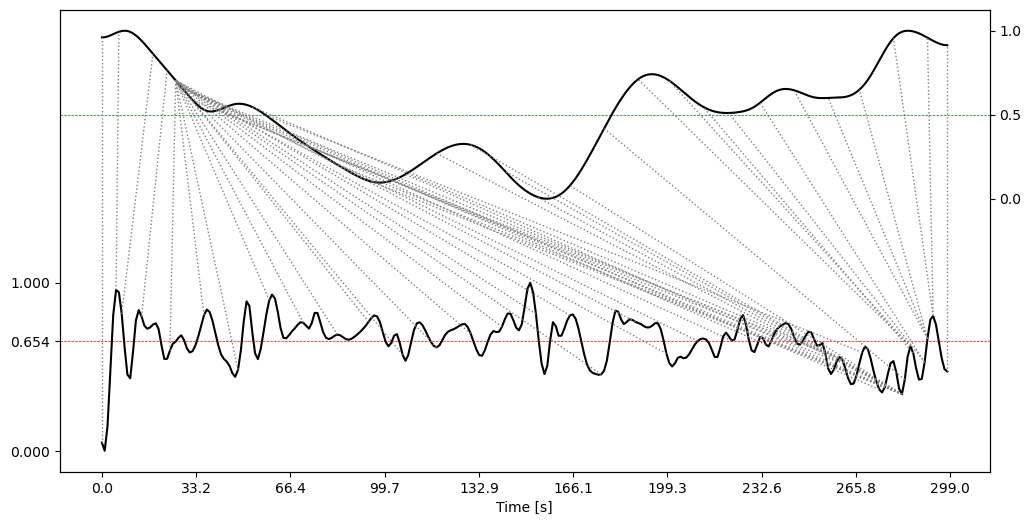

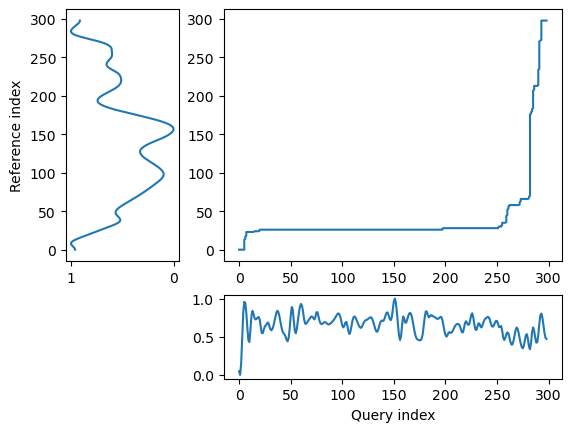

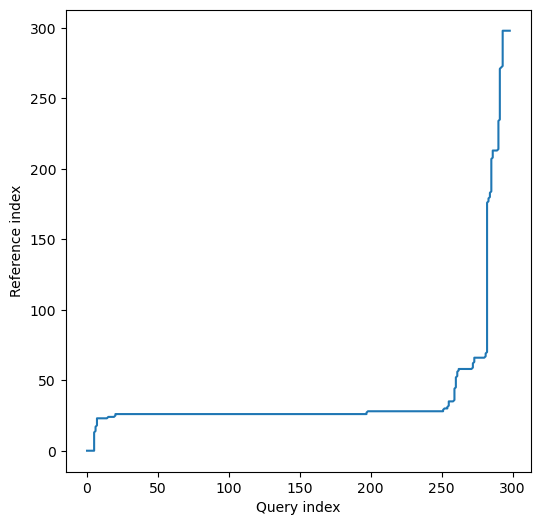

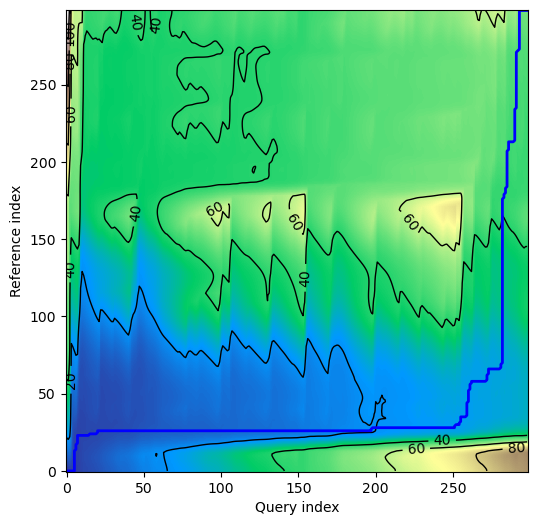

In [19]:
# Apply DTW to imf_sum and hr
alignment = dtw(imf_hr, imf_mx, keep_internals=True)
print(f"Alignment distance for series {file_number}: {alignment.distance}")
normalized_distance = alignment.distance / (len(imf_hr) + len(imf_mx))
print(f"Normalized distance for series {file_number}: {normalized_distance}")
# ``twoway`` plots a point-by-point comparison, with matching lines
customDtwPlotTwoWay(alignment, offset=1.5, xlab="Time [s]")


# ``threeway`` vis-a-vis inspection of the timeseries and their warping
#    curve; see [dtwPlotThreeWay()]
alignment.plot(type="threeway")

# ``alignment`` plots the warping curve in ``d``
alignment.plot(type="alignment")

# ``density`` displays the cumulative cost landscape with the warping
#    path overimposed; see [dtwPlotDensity()]
alignment.plot(type="density")
plt.show()

In [20]:
import numpy as np
import torch
import torch.nn.functional as F

def compute_all_costs(X, Z, gamma_xz, drop_cost_type, keep_percentile, l2_normalize=False):
    """This function computes pairwise match and individual drop costs used in Drop-DTW for two time series

    Parameters
    __________

    X: torch.tensor of size [n] or [n, d]
        First series.
    Z: torch.tensor of size [m] or [m, d]
        Seccond series.
    gamma_xz: float
        Scaling factor for the softmax computation.
    drop_cost_type: str
        The type of drop cost definition, i.g., learnable or logits percentile.
    keep_percentile: float in [0, 1]
        if drop_cost_type == 'logit', defines drop (keep) cost threshold as logits percentile
    l2_normalize: bool
        Whether to normalize the time series before computing the costs
    """

    # Convert to torch.tensor
    time_series1 = torch.tensor(X)
    time_series2 = torch.tensor(Z)
    
    # Ensure the time series are 2D for consistency
    if time_series1.dim() == 1:
        time_series1 = time_series1.unsqueeze(1)
    if time_series2.dim() == 1:
        time_series2 = time_series2.unsqueeze(1)

    if l2_normalize:
        time_series1 = F.normalize(time_series1, p=2, dim=1)
        time_series2 = F.normalize(time_series2, p=2, dim=1)
    
    # Compute similarity matrix between the two time series
    sim = time_series1 @ time_series2.T

    if drop_cost_type == 'logit':
        k = max([1, int(torch.numel(sim) * keep_percentile)])
        baseline_logit = torch.topk(sim.reshape([-1]), k).values[-1].detach()
        baseline_logits = baseline_logit.repeat([1, sim.shape[1]])  # making it of shape [1, N]
        sims_ext = torch.cat([sim, baseline_logits], dim=0)
    elif drop_cost_type == 'learn':
        # Assuming distractor is provided as a parameter
        distractor = torch.mean(time_series2, dim=0)  # Example distractor, can be modified
        distractor_sim = time_series1 @ distractor
        sims_ext = torch.cat([sim, distractor_sim[None, :]], dim=0)
    else:
        assert False, f"No such drop mode {drop_cost_type}"

    unique_softmax_sims = torch.nn.functional.softmax(sims_ext / gamma_xz, dim=0)
    unique_softmax_sim, drop_probs = unique_softmax_sims[:-1], unique_softmax_sims[-1]
    matching_probs = unique_softmax_sim
    zx_costs = -torch.log(matching_probs + 1e-5)
    drop_costs = -torch.log(drop_probs + 1e-5)
    return zx_costs, drop_costs, drop_probs

# Example usage with 1D data
time_series1 = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
time_series2 = torch.tensor([1.5, 2.5, 3.5, 4.5, 5.5])
gamma_xz = 1.0
drop_cost_type = 'logit'
keep_percentile = 0.5
l2_normalize = False

zx_costs, drop_costs, drop_probs = compute_all_costs(time_series1, time_series2, gamma_xz, drop_cost_type, keep_percentile, l2_normalize)
print("zx_costs:", zx_costs)
print("drop_costs:", drop_costs)
print("drop_probs:", drop_probs)

zx_costs: tensor([[8.5475e+00, 9.9287e+00, 1.1435e+01, 1.1511e+01, 1.1513e+01],
        [7.0883e+00, 7.6373e+00, 1.0213e+01, 1.1386e+01, 1.1506e+01],
        [5.5977e+00, 5.1566e+00, 7.0199e+00, 8.9324e+00, 1.0533e+01],
        [4.0998e+00, 2.6581e+00, 3.5309e+00, 4.5103e+00, 5.5016e+00],
        [2.6003e+00, 1.5828e-01, 3.1189e-02, 1.1165e-02, 4.0851e-03]])
drop_costs: tensor([ 0.1004,  2.6581,  7.5127, 11.1992, 11.5104])
drop_probs: tensor([9.0448e-01, 7.0068e-02, 5.3610e-04, 3.6852e-06, 2.5007e-08])


C:\Users\Admin\AppData\Local\Temp\ipykernel_2224\3731208434.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series1 = torch.tensor(X)
C:\Users\Admin\AppData\Local\Temp\ipykernel_2224\3731208434.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_series2 = torch.tensor(Z)


In [21]:
zx_costs, drop_costs, _ = compute_all_costs(mx[3], hr[3], gamma_xz, drop_cost_type, keep_percentile, l2_normalize)
print(zx_costs)
print(drop_costs)


tensor([[11.5129, 11.5129, 11.5129,  ..., 11.5129, 11.5129, 11.5129],
        [11.5129, 11.5129, 11.5129,  ..., 11.5129, 11.5129, 11.5129],
        [11.5129, 11.5129, 11.5129,  ..., 11.5129, 11.5129, 11.5129],
        ...,
        [ 2.1499,  2.1465,  2.0664,  ...,  2.1300,  2.1219,  2.1098],
        [ 1.4670,  1.4660,  1.4467,  ...,  1.4616,  1.4595,  1.4564],
        [ 0.5533,  0.5557,  0.6177,  ...,  0.5673,  0.5732,  0.5823]])
tensor([11.5129, 11.5129, 11.5128, 11.5128, 11.5129, 11.5129, 11.5129, 11.5129,
        11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129,
        11.5129, 11.5128, 11.5128, 11.5128, 11.5127, 11.5128, 11.5128, 11.5128,
        11.5128, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5129,
        11.5129, 11.5129, 11.5129, 11.5129, 11.5129, 11.5128, 11.5128, 11.5129,
        11.5129, 11.5129, 11.5128, 11.5129, 11.5129, 11.5129, 11.5128, 11.5128,
        11.5129, 11.5128, 11.5128, 11.5128, 11.5129, 11.5129, 11.5128, 11.5128,
      

In [22]:
# Print information for mx[3]
print("Information for mx[3]:")
print(f"Type: {type(mx[3])}")
print(f"Size: {mx[3].size}")
print(f"Shape: {mx[3].shape}")
print(f"Dimensionality: {mx[3].ndim}")

# Print information for hr[3]
print("\nInformation for hr[3]:")
print(f"Type: {type(hr[3])}")
print(f"Size: {hr[3].size}")
print(f"Shape: {hr[3].shape}")
print(f"Dimensionality: {hr[3].ndim}")

Information for mx[3]:
Type: <class 'numpy.ndarray'>
Size: 204
Shape: (204,)
Dimensionality: 1

Information for hr[3]:
Type: <class 'numpy.ndarray'>
Size: 204
Shape: (204,)
Dimensionality: 1


In [23]:
print(list(range(6)))

[0, 1, 2, 3, 4, 5]
